In [2]:
%load_ext autoreload
%autoreload 2

%load_ext dotenv
%dotenv src/.env

In [25]:
import os
os.chdir('/Users/kushagrasharma/coding/hormozlab/src')

import numpy as np
from numpy import linalg
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import torchvision

from tqdm import tqdm

from src.AutoEncoder import AE, Encoder, Decoder
from src.Binary2LatentNN import Binary2LatentNN
from src.Binary2TranscriptomeNN import Binary2TranscriptomeNN
from src.utils import *

import seaborn as sns
%matplotlib inline

In [4]:
DATA_DIR = os.environ.get("DATA_DIR")
MODELS_DIR = os.environ.get("MODELS_DIR")

binary_matrix_filepath = MODELS_DIR + 'binary_matrix.npy'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We will now display the results of our analyses. As a reminder, the goal is to determine the best method for reconstructing cell state / transcriptome data from a low-dimensional, binary combination of genes that is experimentally feasible to measure. Previous analyses have found that the particular genes and combinations that are being taken do not have a large impact on reconstruction accuracy, thus we use a preselected random matrix for all our computations, with the experimentally feasible parameters $50$ genes per combination with $10$ total binary combinations. 

Our primary evaluation metric is the cross-entropy between the reconstructed distribution and the ground truth distribution; the Gaussian analogue we previously constructed. Our secondary evaluation metric is the mean squared error between the ground truth transcriptome and the reconstructed transcriptome. We determine the reconstructed transcriptome by taking a weighted average of the training cells as indicated by the reconstructed distribution.

For cells not in the training set that are thereby lacking a ground truth measurement (e.g. the validation and test sets), we use the closest cell in the training set to the given cell to construct a ground truth distribution to evaluate in comparison to. 

In [5]:
### Loading Data
binary_matrix = torch.tensor(np.load(binary_matrix_filepath)).float()

train_full = pd.read_csv(DATA_DIR + 'scvi_train_set_gapdh.csv', header=None).to_numpy()
test_full = pd.read_csv(DATA_DIR + 'scvi_test_set_gapdh.csv', header=None).to_numpy()
valid_full = pd.read_csv(DATA_DIR + 'scvi_valid_set_gapdh.csv', header=None).to_numpy()

train_umap = pd.read_csv(DATA_DIR + 'train_coords.csv', header=None).to_numpy()
test_umap = pd.read_csv(DATA_DIR + 'test_coords.csv', header=None).to_numpy()
valid_umap = pd.read_csv(DATA_DIR + 'valid_coords.csv', header=None).to_numpy()

train_tensor = torch.tensor(train_full).float()
valid_tensor = torch.tensor(valid_full).float()
test_tensor = torch.tensor(test_full).float()

train_binary_tensor = torch.matmul(train_tensor, binary_matrix)
valid_binary_tensor = torch.matmul(valid_tensor, binary_matrix)
test_binary_tensor = torch.matmul(test_tensor, binary_matrix)

gaussian_train = np.load(DATA_DIR + 'truncated_gaussian_sigma_10thNN.npy')

closest_cell_to_valid = np.load(DATA_DIR + 'closest_cell_to_valid.npy')
closest_cell_to_test = np.load(DATA_DIR + 'closest_cell_to_test.npy')

gaussian_valid = np.apply_along_axis(lambda x: gaussian_train[x,:], 0, closest_cell_to_valid)
gaussian_test = np.apply_along_axis(lambda x: gaussian_train[x,:], 0, closest_cell_to_test)

graph = np.load(DATA_DIR + "adjacency_15NN.npy")

N_train_cells = len(graph)
N_test_cells = len(test_tensor)

### Get Laplacian
laplacian_all = get_laplacian_from_tome_data(train_full)

### Compute eigen
lambda_all, v_all = get_laplacian_eig_from_laplacian(laplacian_all)

## Distribution Reconstruction
We begin with our primary evaluation, the distribution reconstruction. We're testing the following methods' reconstruction accuracy (all beginning with the binary linear combination of genes):
1. Using a neural network to reconstruct the first 100 Laplacian eigenvalues, and then using the Laplacian eigenfunctions to reconstruct the distribution
2. Using a neural network to reconstruct the whole transcriptome, then using the transcriptome to reconstruct a distribution over cells
3. Using a neural network to reconstruct the whole transcriptome, then using a neural network to reconstruct the first 100 Laplacian eigenvalues, and then using the Laplacian eigenfunctions to reconstruct the distribution
4. Using a neural network to directly reconstruct the distribution over cells

We're comparing these methods to the following positive controls:
1. Using the true first 100 principal components of the transcriptome of a cell, followed by a neural network reconstruction of the probability distribution
2. Using the true first 100 Laplacian eigenvalues, and then using the Laplacian eigenfunctions to reconstruct the distribution

And the following negative controls:
1. A uniform distribution over cells 
2. A random distribution over cells, $p(i)\propto R$ where $R$ is a random real number in $[0,1]$

In [47]:
### Load Models

binaryToLaplacian = torch.load(MODELS_DIR + 'binaryToLaplacian.pt').eval()
binaryToTome = torch.load(MODELS_DIR + 'binaryToTomeNoBottleneck.pt').eval()
tomeToLaplacian = torch.load(MODELS_DIR + 'tomeToLaplacian.pt').eval()
binaryToGaussian = torch.load(MODELS_DIR + 'binaryToGaussian.pt').eval()
tomeToGaussian = torch.load(MODELS_DIR + 'tomeToGaussian.pt').eval()
PCA2Gaussian = torch.load(MODELS_DIR + 'PCAToGaussian.pt').eval()

In [50]:
### Methods
toGraph = lambda X: np.apply_along_axis(lambda y: laplacian_coefficients_to_probability(y, v_all), 1, X)
toTensor = lambda x: torch.tensor(x).float()

def transform(X, transforms):
    d = torch.clone(X)
    for transform in transforms:
        d = transform(d)
    return d

def transform_and_compute_error(X, Y, transforms, error):
    ## Returns the final reconstruction and the error
    d = transform(X, transforms)
    return d, error(Y, d)

# Using a neural network to reconstruct the first 100 Laplacian eigenvalues
# Then using the Laplacian eigenfunctions to reconstruct the distribution
dist_one = [binaryToLaplacian, toGraph]

# Using a neural network to reconstruct the whole transcriptome
# Then using the transcriptome to reconstruct a distribution over cells
dist_two = [binaryToTome, tomeToGaussian]

# Using a neural network to reconstruct the whole transcriptome 
# Then using a neural network to reconstruct the first 100 Laplacian eigenvalues
# Then using the Laplacian eigenfunctions to reconstruct the distribution

dist_three = [binaryToTome, tomeToLaplacian, toGraph]

# Using a neural network to directly reconstruct the distribution over cells

dist_four = [binaryToGaussian]

### Positive controls
train_pca = np.load(DATA_DIR + 'train_100_pca.npy')
test_pca = train_pca[closest_cell_to_test,:]
test_pca = toTensor(test_pca)

test_laplacian_coeffs = np.array([get_laplacian_coefficients(gaussian_test[i,:], 
                                                      v_all)[:100] for i in range(len(gaussian_test))])
test_laplacian_coeffs = toTensor(test_laplacian_coeffs)

### Negative controls

nc_one = np.ones(N_train_cells) / N_train_cells
nc_one = np.tile(nc_one, (N_test_cells, 1))
nc_one = toTensor(nc_one)

nc_two = np.random.rand(N_test_cells, N_train_cells)
row_sums = nc_two.sum(axis=1)
nc_two = nc_two / row_sums[:, np.newaxis]
nc_two = toTensor(nc_two)
del row_sums

In [62]:
with torch.no_grad():
    ### Methods
    one, one_error = transform_and_compute_error(test_binary_tensor, gaussian_test, 
                                            dist_one, cross_entropy_on_matrix)[1]

    two, two_error = transform_and_compute_error(test_binary_tensor, gaussian_test, 
                                            dist_two, cross_entropy_on_matrix)[1]
    
    three, three_error = transform_and_compute_error(test_binary_tensor, gaussian_test, 
                                            dist_three, cross_entropy_on_matrix)[1]
    
    four, four_error = transform_and_compute_error(test_binary_tensor, gaussian_test, 
                                            dist_four, cross_entropy_on_matrix)[1]
    
    ### Positive controls
    pc_one, pc_one_error = transform_and_compute_error(test_pca, gaussian_test, [PCA2Gaussian], 
                                               cross_entropy_on_matrix)[1]
    
    pc_two, pc_two_error = transform_and_compute_error(test_laplacian_coeffs, gaussian_test, 
                                         [toGraph], cross_entropy_on_matrix)[1]
    
    ### Negative controls
    nc_one, nc_one_error = cross_entropy_on_matrix(nc_one, gaussian_test)
    
    nc_two, nc_two_error = cross_entropy_on_matrix(nc_two, gaussian_test)

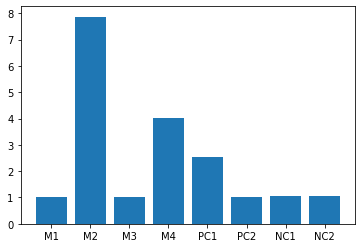

In [63]:
labels = ["M1", 'M2', 'M3', 'M4', 'PC1', 'PC2', 'NC1', 'NC2']
errors = [one_error, two_error, three_error, four_error, pc_one_error, pc_two_error, nc_one_error, nc_two_error]
plt.bar(labels, errors)

plt.show()

| Method Code | Description                                           |
|-------------|-------------------------------------------------------|
| M1          | NN Reconstruction of 100 Laplacian Coeff.             |
| M2          | NN T-ome Reconstruction, then NN Dist. Reconstruction |
| M3          | NN T-ome Reconstruction -> NN Laplacian Coeff.        |
| M4          | NN Dist. Reconstruction                               |
| PC1         | Positive Control: 100 PC Loadings                     |
| PC2         | Positive Control: 100 Laplacian Coeff.                |
| NC1         | Negative Control: Uniform Dist.                       |
| NC2         | Negative Control: Random Dist.                        |

## Transcriptome Reconstruction
Next is our secondary evaluation, the transcriptome reconstruction, using mean squared error loss. We're testing the following methods' reconstruction accuracy (all beginning with the binary linear combination of genes):
1. Using a neural network to reconstruct the first 100 Laplacian eigenvalues, then using the Laplacian eigenfunctions to reconstruct the distribution, then taking a weighted average of the transcriptomes of cells in the distribution
2. Using a neural network to reconstruct the first 100 Laplacian eigenvalues, then using a neural network to reconstruct the whole transcriptome
3. Using a neural network to directly reconstruct the whole transcriptome
4. Using a bottlenecked neural network to reconstruct the whole transcriptome

We're comparing these methods to the following positive controls:
1. The ground truth transcriptome with multivariate Gaussian noise, with standard deviation calculated from each gene's expression levels
1. Using the true first 100 principal components of the transcriptome of a cell, followed by a neural network reconstruction of the transcriptome
2. Using the true first 100 Laplacian eigenvalues, followed by a neural network reconstruction of the transcriptome

And the following negative controls:
1. The average transcriptome of all cells on the graph
2. A random transcriptome drawn from a multivariate Gaussian centered on the average transcriptome with standard deviation calculated from each gene's expression levels
3. A random cell's transcriptome drawn from the training set